In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn import metrics

In [2]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Correlation map

/tmp/ipykernel_5442/1342149493.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_cct.corr())


<Axes: >

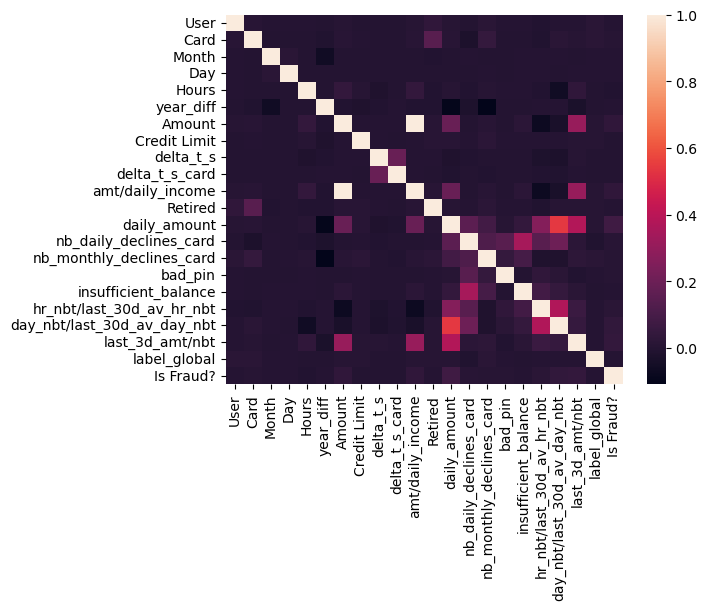

In [3]:
sns.heatmap(df_cct.corr())

In [5]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?'],
      dtype='object')

### Preprocessing (code to create standarized (by User) dataset)

In [48]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df_cct.loc[:,~df_cct.columns.isin(["User","Card","label_global","Retired", "bad_pin", "insufficient_balance","Is Fraud?"])].select_dtypes(include=numerics).columns.to_list()
cat = df_cct.select_dtypes(include=['object']).columns.to_list()


In [49]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df = pd.DataFrame()
for i in range(2000):
    user_i = df_cct[df_cct["User"] == i]
    user_i[num] = scaler.fit_transform(user_i[num])
    df = pd.concat([df,user_i], axis=0)


/tmp/ipykernel_3474/3353035098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_i[num] = scaler.fit_transform(user_i[num])
/tmp/ipykernel_3474/3353035098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_i[num] = scaler.fit_transform(user_i[num])
/tmp/ipykernel_3474/3353035098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [51]:
#df.to_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Encode categorical variables

In [3]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [4]:
# Pour "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [5]:
# Pour "Card Type"":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

### Manually create train/test datasets

In [6]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Amex', 'Discover', 'Mastercard', 'Visa', 'Credit',
       'Debit', 'Debit (Prepaid)', "label_global","Is Fraud?"]
df_selec = df_cct[features]

In [7]:
import random
random.seed(42)
df_train = pd.DataFrame()
for i in range(-1,7,1):
    cluster_i_list = df_selec[df_selec["label_global"] == i].index.tolist()
    index = random.sample(cluster_i_list, int(len(df_selec[df_selec["label_global"] == i])*0.4))
    df_rs = df_selec.loc[index]
    df_train = pd.concat([df_train, df_rs], axis = 0)

In [8]:
#train set
X_train = df_train.drop(["label_global","Is Fraud?"], axis = 1).reset_index(drop=True)
y_train = df_train["Is Fraud?"].reset_index(drop=True)

In [9]:
#test set 
df_rest = df_selec[~df_selec.index.isin(df_train.index)]
df_rest_fraud = df_rest[df_rest["Is Fraud?"] == 1]
df_rest_no_fraud = df_rest[df_rest["Is Fraud?"] == 0]
df_test = pd.concat([df_rest_fraud, df_rest_no_fraud.sample(480000, random_state = 42)], axis = 0)
df_test.sort_index(ascending=True, inplace=True)

In [10]:
X_test = df_test.drop(["label_global", "Is Fraud?"], axis = 1)
y_test = df_test["Is Fraud?"]

### Modeling

In [12]:
df_f1_score = pd.DataFrame()
for i in range(1, 21, 2):
    dt = DecisionTreeClassifier(min_samples_leaf=i)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score = df_f1_score.append([[i, score]])
df_f1_score    

/tmp/ipykernel_14557/2769420714.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_f1_score = df_f1_score.append([[i, score]])
/tmp/ipykernel_14557/2769420714.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_f1_score = df_f1_score.append([[i, score]])
/tmp/ipykernel_14557/2769420714.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_f1_score = df_f1_score.append([[i, score]])
/tmp/ipykernel_14557/2769420714.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_f1_score = df_f1_score.append([[i, score]])
/tmp/ipykernel_14557/2769420714.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pand

,0,1
0,1,0.264151
0,3,0.228984
0,5,0.208994
0,7,0.199050
0,9,0.185594
0,11,0.177118
0,13,0.169866
0,15,0.164708
0,17,0.155537
0,19,0.157328


In [22]:
for i in range(20, 200, 30):
    dt = DecisionTreeClassifier(min_samples_leaf=i)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score = df_f1_score.append([[i, score]])
df_f1_score    

/tmp/ipykernel_14557/2284119990.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_f1_score = df_f1_score.append([[i, score]])
/tmp/ipykernel_14557/2284119990.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_f1_score = df_f1_score.append([[i, score]])
/tmp/ipykernel_14557/2284119990.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_f1_score = df_f1_score.append([[i, score]])
/tmp/ipykernel_14557/2284119990.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_f1_score = df_f1_score.append([[i, score]])
/tmp/ipykernel_14557/2284119990.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pand

,0,1
0,1,0.264151
0,3,0.228984
0,5,0.208994
0,7,0.199050
0,9,0.185594
0,11,0.177118
0,13,0.169866
0,15,0.164708
0,17,0.155537
0,19,0.157328


Text(0.5, 1.0, 'f1-score according to min_samples_leaf (decision tree)')

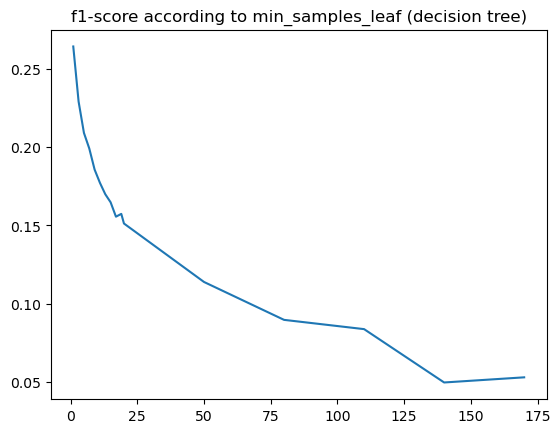

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score.iloc[:,0].values, df_f1_score.iloc[:,1].values)
plt.title('f1-score according to min_samples_leaf (decision tree)')

### Evaluating

In [24]:
# Build and train model
decision_tree = DecisionTreeClassifier(min_samples_leaf=1)
decision_tree.fit(X_train, y_train)
# Apply model to validation data
y_pred = decision_tree.predict(X_test)

In [25]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_pred))

Classification metrics: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    480000
           1       0.82      0.16      0.26     17913

    accuracy                           0.97    497913
   macro avg       0.90      0.58      0.62    497913
weighted avg       0.96      0.97      0.96    497913



In [26]:
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()

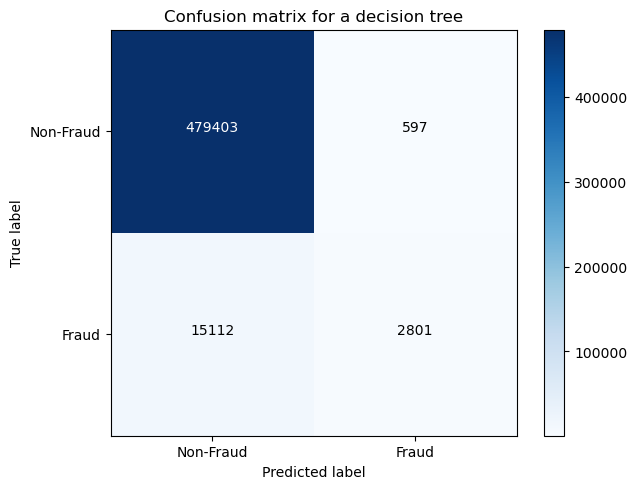

In [27]:

cnf_matrix_dtree = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree')
plt.show()

In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
cost = fp*15 + fn*45 - tp*45
cost

424275